# Registering a Single Slice to a Stack of Images

__Purpose:__ Registering immunofluorescent whole brain slice images to a universal atlas and then saving the registered images into a stack.  
           
NOTE: The notebook and package is currently developed for the workflow specific to the Nance Lab.

__How the notebook works:__
1. Accesses your Google Drive to pull files from
2. Accesses the specific folder in Google drive with stored brain slice images
3. Accesses your distances file for correlation of slices to an atlas
4. Accesses the atlas segmentation file
5. Loops through the files performing registration
   * Downloads a file
   * Cleans the files
   * Obtains registration points for your image and atlas image
   * Obtains registration coefficients for the transformation
   * Performs the registration
   * Saves the slice to a stack of images
   * Deletes the file
   * Moves to the next file and repeats steps
6. Prints the stack of images for visual inspection

__How to use the notebook__:  

1. Store you slices in a Google Folder with the naming system 'slide#_slice#'
2. Store your distances file in the same folder as 'distances.xlsx'
3. Store your atlas in the same file under your desired name
2. Input the Google Folder ID of neural slices (final part of the url) into the folder_id in Step 2
3. Input the name of the atlas in the atlas_file_name input of step 2
4. Run the whole notebook
5. When a second tab opens, log into your Google Drive account
6. Allow access to Quickstart
    * DO NOT CLOSE THE TAB ONCE 'AUTHENTICATION FLOW IS COMPLETED' APPEARS
7. Allow the notebook to run

*Step 1: Importing Necessary Packages*

In [1]:
import os
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
import pandas as pd
import nrrd
import nibabel as nib
import io
from googleapiclient.http import MediaIoBaseDownload

import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

#Importing files from my packages
import ifmodels.register as register
import ifmodels.gdaccess as gdaccess
import ifmodels.preprocess as preprocess

*Step 2: User inputs*

In [29]:
folder_id = "'1GDUl93_NWjLS9qAVIdA1UukD3UqItFvo'"
atlas_file_name = 'atlas_segmentation.nrrd'
slice_name = 'slide65_slice2.tif'

*Step 3: Getting Google Drive Access*

In [3]:
import pydrive
from pydrive.auth import GoogleAuth as gauth
from pydrive.drive import GoogleDrive

from pydrive.auth import GoogleAuth

#  Creates local webserver and auto handles authentication.
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

#  Create GoogleDrive instance with authenticated GoogleAuth instance
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=311511771285-g66b7tm0525pnntbr67mv9t6qjud4bgk.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


*Step 4: Get list of file names and file ids from specified google folder*

In [32]:
string = folder_id + ' in parents and trashed=false'

In [33]:
file_list = drive.ListFile({'q': string}).GetList()
names = []
ids = []
for file1 in file_list:
    names.append(file1['title'])
    ids.append(file1['id'])

In [34]:
file_names = pd.DataFrame(list(zip(names, ids)), columns = ['names','ids'])
file_names

,names,ids
0,atlas_segmentation.nrrd,1Pj_D6bo-zdiJ9JoTq8-ViusRUCbz3h64
1,distances.xlsx,1gJXjESKZ5AVxKHp4Lf-3WVJHmGQ72ihr
2,slide66_slice3.tif,1A2Z0H0NsceFH7YrweRwWh84g07KgCeuR
3,slide67_slice2.tif,1pk4aB4JDTyYAC2924WZdSJT3wZ_dpe1b
4,slide66_slice2.tif,1QUC74m7A2kgVP2FPOVIXKGQY_C0BljZ9
5,slide66_slice1.tif,1kpQ-DRPLV4iC3HY8BGxklXCtp3BgTlkX
6,slide65_slice3.tif,1uESvcrpkbztEwQbMR0Y0xp25VpfOU5cf
7,slide65_slice2.tif,1cDBPRtVgq_Lf_gFF4dWKNdJbJCmXSaD7
8,slide65_slice1.tif,1oKN8sGQ4Yl7yKoCigyDR8qWlgIbs4ae_
9,slide64_slide3.tif,1TespqYjQSAqMF9uUVpR02MJi3qnCJlqq


*Step 5: Accessing the distances file and reading into a dataframe*

In [35]:
distances_file = file_names.loc[file_names['names'] == 'distances.xlsx']
distances_file = distances_file.reset_index()

gdistances = drive.CreateFile({'id': distances_file['ids'][0]})
gdistances.GetContentFile(distances_file['names'][0])

corr_atlas = pd.read_excel(distances_file['names'][0])

file_names = file_names[file_names.names!= 'distances.xlsx']

*Step 6: Accessing the universal atlas*

In [36]:
atlas_file = file_names.loc[file_names['names'] == atlas_file_name]
atlas_file = atlas_file.reset_index()

gatlas= drive.CreateFile({'id': atlas_file['ids'][0]})
gatlas.GetContentFile(atlas_file['names'][0])

F_im_nii = register.nrrd_to_nii(atlas_file_name)

file_names = file_names[file_names.names!= atlas_file_name]

*Step 7: Initializing a value and array for registration use in Step 8*

In [37]:
Registered_stack = np.zeros((9, 4280, 3200))

*Step 8: Full code for pulling and registering files from google drive*

In [38]:
file_id = file_names.loc[file_names['names'] == slice_name]
file_id = file_id.reset_index()

*Step 9: Downloading the slice to be registered (moving image)*

In [39]:
file6 = drive.CreateFile({'id': file_id['ids'][0]})
file6.GetContentFile(file_id['names'][0])

*Step 10: Cleaning up the moving image and getting registration points*

In [50]:
im = register.im_read(file_id['names'][0])
binary1 = register.mim_edge_detector(im)
binary2 = register.image_cleaning(binary1)
coor_df = register.find_points(binary2)

__Visualization 1: Original Slice__

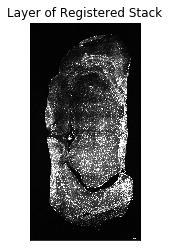

In [46]:
plt.imshow(im, cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

__Visualization 2: Binary Slice__

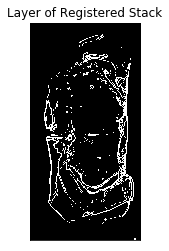

In [47]:
plt.imshow(binary1, cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

__Visualization 3: small Objects Removed__

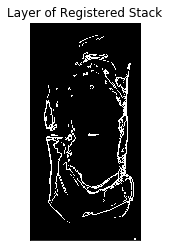

In [51]:
plt.imshow(binary2, cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

__Visualization 4: Registration Coordinates__

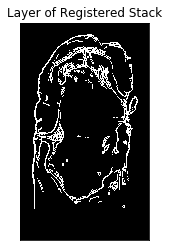

In [49]:
plt.imshow(binary, cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

*Step 11: Getting the proper atlas slice and its registration points*

In [ ]:
slice = corr_atlas.loc[corr_atlas['Slidetag'] == new_file_name[:-4]].values.tolist()[0]
slice_number = slice[1]
sagittal, coronal, horizontal = register.atlas_slice(F_im_nii, slice_number)
resized = preprocess.resize(coronal, 20)
resized = register.mim_edge_detector(resized)
fim_coor_df = register.find_points(resized)

*Step 12: Performing the affine transformation to get registration coordinates*

In [ ]:
df = pd.concat([coor_df, fim_coor_df], axis = 1)
ainv = register.reg_coefficients(df, 1, 3, 5)

*Step 13: Registering the Slice*

In [ ]:
registered_im = register.registration(im, ainv)
Registered_stack[k] = registered_im

1 slide66_slice3.tif
2 slide67_slice2.tif


*Step 14: Removing the file from my personal computer*

In [ ]:
os.remove(new_file_name)

*Step 9: Saving the created stack as a Nifti File*

In [ ]:
full_brain = nib.Nifti2Image(Registered_stack, affine=np.eye(4))

*Visualization 1: Looking at an individual slice*

In [ ]:
plt.imshow(Registered_stack[4], cmap = 'gray')
plt.title('Layer of Registered Stack')
plt.xticks([])
plt.yticks([])

plt.show()

*Visualization 2: Looking at the full stack of slices side by side*